In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms

from binaryconnect import BC
from models import DenseNet121
from utils import get_device, get_model_size_mb, get_test_cifar10_dataloader, test

In [2]:
from torch import dtype as T_dtype
from torch.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.utils.data.dataloader import DataLoader

QCONFIG = get_default_qconfig('fbgemm')
QCONFIG_DEFAULT = {
    "": QCONFIG,
    "object_type": [
        (torch.nn.Conv2d, QCONFIG),
        (torch.nn.Linear, QCONFIG),
        (torch.nn.ReLU, QCONFIG),
        (torch.nn.BatchNorm2d, QCONFIG),
    ]
}

def quantise_dynamic(
        model: nn.Module,
        spec: tuple = {torch.nn.Linear},
        dtype: T_dtype = torch.qint8,
    ) -> nn.Module:
    return torch.quantization.quantize_dynamic(
        model, spec, dtype=dtype,
    )

def quantise_static(
        model: nn.Module,
        calibration_loader: DataLoader,
        qconfig_dict: dict = QCONFIG_DEFAULT,
    ) -> nn.Module:
    model = model.to('cpu')
    example_inputs = (next(iter(calibration_loader))[0],)
    prepared_model = prepare_fx(model, qconfig_dict, example_inputs)
    return convert_fx(prepared_model)

In [ ]:
import pickle
device = get_device()

with open("train_results.pkl", "rb") as f:
    res = pickle.load(f)
state_dict, acc, train_accs, val_accs = res.values()

model = DenseNet121()
model.load_state_dict(state_dict)

model = model.to(device)

In [4]:
test_loader = get_test_cifar10_dataloader()

In [6]:
og_acc, _ = test(
    test_loader,
    model,
)

In [7]:
og_acc

90.44

In [19]:
og_size = get_model_size_mb(model)
og_size

28.353676

In [14]:
model.to("cpu")
dynamic_quantised_model = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8,
    )
dynamic_quantised_size = get_model_size_mb(dynamic_quantised_model)
dynamic_quantised_size

28.313666

In [2]:
import pickle

with open("thinet_prune_half_quant.pkl", "rb") as f:
    res = pickle.load(f)

In [3]:
res

[(0.2, 18.31, 0.7322058681589754, 5630117),
 (0.3, 10.0, 0.6092079834848477, 4951368),
 (0.4, 10.0, 0.4956531306144839, 4272135),
 (0.5, 10.08, 0.38176272222580515, 3525034)]

Text(0, 0.5, 'Score')

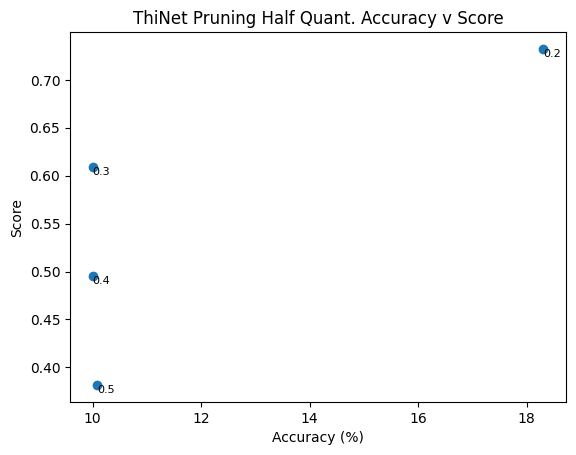

In [6]:
import matplotlib.pyplot as plt


x = [r[1] for r in res]
y = [r[2] for r in res]

plt.scatter(x, y)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi, yi, f"{res[i][0]}", fontsize=8, ha='left', va='top')


plt.title("ThiNet Pruning Half Quant. Accuracy v Score")
plt.xlabel("Accuracy (%)")
plt.ylabel("Score")

In [15]:
dynamic_quantised_acc, _ = test(
    test_loader,
    dynamic_quantised_model,
    device="cpu"
)

In [16]:
dynamic_quantised_acc

90.38

In [20]:
model.eval() 
static_quantised_model = quantise_static(model, test_loader)
static_quantised_size = get_model_size_mb(static_quantised_model)
static_quantised_size

/users/local/b24richa/EDL/.venv/lib/python3.12/site-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  prepared = prepare(
/users/local/b24richa/EDL/.venv/lib/python3.12/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/users/local/b24richa/EDL/.venv/lib/python3.12/site-packages/torch/ao/quantization/observer.py:1318: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


7.89627

In [25]:
static_quantised_model = static_quantised_model.to("cpu")

In [21]:
static_quantised_acc, _ = test(
    test_loader,
    static_quantised_model,
    device="cpu"
)

In [22]:
static_quantised_acc

10.0

In [24]:
model = model.to(device)
half_model = model.half()
half_model_size = get_model_size_mb(half_model)
half_model_size

14.27406

In [25]:
half_model_acc, _ = test(
    test_loader,
    half_model,
    half=True
)

In [26]:
half_model_acc

90.42

In [44]:
from utils import get_best_transformations, get_cifar10_train_val_loaders, load_untrained_model, run_epochs, get_dataloader, get_train_cifar10_dataset

train_transforms = get_best_transformations()
training_details = load_untrained_model("DenseNet121")
# train_loader, val_loader = get_cifar10_train_val_loaders()
train_loader = get_dataloader(get_train_cifar10_dataset(subset=True, num_subset=1000))
val_loader = get_dataloader(get_train_cifar10_dataset(subset=True, num_subset=200))

In [60]:
model.train()
# model.to("cpu")
model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model, inplace=True)

best_acc, train_accs, test_accs = run_epochs(
    training_details["model"],
    train_loader,
    val_loader,
    training_details,
    n_epochs=1,
)


Epoch: 0
Saving..


In [61]:
model.to("cpu")
qat_model = torch.quantization.convert(model, inplace=True)

In [62]:
get_model_size_mb(qat_model)

8.07959

In [63]:
# qat_model.to("cpu")
qat_acc, _ = test(
    test_loader,
    qat_model,
    device="cpu"
)

NotImplementedError: Could not run 'quantized::conv2d.new' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::conv2d.new' is only available for these backends: [Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMeta, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at /pytorch/aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
QuantizedCPU: registered at /pytorch/aten/src/ATen/native/quantized/cpu/qconv.cpp:2045 [kernel]
QuantizedCUDA: registered at /pytorch/aten/src/ATen/native/quantized/cudnn/Conv.cpp:391 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:503 [backend fallback]
Functionalize: registered at /pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:100 [backend fallback]
AutogradOther: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMPS: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:91 [backend fallback]
AutogradXPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:104 [backend fallback]
AutogradLazy: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:87 [backend fallback]
AutogradMTIA: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMeta: registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:95 [backend fallback]
Tracer: registered at /pytorch/torch/csrc/autograd/TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:322 [backend fallback]
AutocastXPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:465 [backend fallback]
AutocastMPS: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:499 [backend fallback]
PreDispatch: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:198 [backend fallback]


In [54]:
qat_model

DenseNet(
  (conv1): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): QuantizedConv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0, bias=False)
      (bn2): QuantizedBatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): QuantizedConv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): QuantizedBatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): QuantizedConv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0, bias=False)
      (bn2): QuantizedBatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): QuantizedConv2d(128

In [ ]:
import torch
from torch.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx

model = model.to('cpu')
model.eval()



example_inputs = (next(iter(train_loader))[0],)
prepared_model = prepare_fx(model, qconfig_dict, example_inputs)
quantized_model = convert_fx(prepared_model)

print(quantized_model)


/users/local/b24richa/EDL/.venv/lib/python3.12/site-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  prepared = prepare(
/users/local/b24richa/EDL/.venv/lib/python3.12/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/users/local/b24richa/EDL/.venv/lib/python3.12/site-packages/torch/ao/quantization/observer.py:1318: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


GraphModule(
  (conv1): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1), bias=False)
  (dense1): Module(
    (0): Module(
      (bn1): QuantizedBNReLU2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): QuantizedConvReLU2d(64, 128, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0)
      (conv2): QuantizedConv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1), bias=False)
    )
    (1): Module(
      (bn1): QuantizedBNReLU2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): QuantizedConvReLU2d(96, 128, kernel_size=(1, 1), stride=(1, 1), scale=1.0, zero_point=0)
      (conv2): QuantizedConv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1), bias=False)
    )
    (2): Module(
      (bn1): QuantizedBNReLU2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Quant

In [29]:
print_size_of_model(quantized_model)

Size (MB): 7.89627


In [20]:
model = model.to("cpu")
for m in model.modules():
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        m.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        torch.quantization.prepare(m, inplace=True)
        torch.quantization.convert(m, inplace=True)
    else:
        continue

/users/local/b24richa/EDL/.venv/lib/python3.12/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [21]:
print(model)

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [16]:
model = model.to("cuda")

In [17]:
print_size_of_model(model)

Size (MB): 28.353676


In [9]:
acc = test(test_loader, model, criterion, "cuda", half=True)

In [9]:

mymodelbc = BC(model)
optimiser = optim.SGD(model.parameters())
criterion = nn.CrossEntropyLoss()
device = "cuda"

train_loader = get_train_cifar10(transform_test, subset=True)

In [10]:

best_acc = 0
start_epoch = 0
n_epochs = 10

for epoch in range(start_epoch, start_epoch+n_epochs):
    mymodelbc.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimiser.zero_grad()
        outputs = mymodelbc(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimiser.step()
        mymodelbc.clip()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()



KeyboardInterrupt: 

In [38]:
from utils import train


def quantise_aware_train(
        train_loader: DataLoader,
        model: nn.Module,
        optimiser: "Optimizer",
        criterion,
        qconfig: str = "fbgemm",
        device: str = "cuda",
        n_epochs: int = 500,
    ) -> None:
    model.qconfig = torch.quantization.get_default_qat_qconfig(qconfig)
    torch.quantization.prepare_qat(model, inplace=True)
    
    for _ in range(n_epochs):
        acc, loss = train(
            train_loader,
            model,
            optimiser,
            criterion,
            device,
        )

    model = model.to('cpu')
    torch.quantization.convert(model, inplace=True)
    model = model.to(device)

In [39]:
from torchvision.transforms import v2 as transformsv2

In [4]:
from utils import get_cifar10_train_val_loaders, ROOT_DIR, DEFAULT_TRANSFORM, print_size_of_model, subset_data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader

train_loader, val_loader = get_cifar10_train_val_loaders(subset=True, num_subset=5000)


# Download CIFAR-10 dataset (train and test)
train_dataset = subset_data(CIFAR10(root=ROOT_DIR, train=True, download=True, transform=DEFAULT_TRANSFORM), 5000)
test_dataset = CIFAR10(root=ROOT_DIR, train=False, download=True, transform=DEFAULT_TRANSFORM)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


# Define a simple model (e.g., for QAT)
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.fc1 = nn.Linear(16 * 30 * 30, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = x.flatten(1)
        x = self.fc1(x)
        return x

# Initialize model, move to CUDA
model = SimpleModel().to('cuda')

print_size_of_model(model)



# Now, the model is quantized and can be used for inference.
print_size_of_model(model)

Size (MB): 0.579704
0


/users/local/b24richa/EDL/.venv/lib/python3.12/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


1
2
3
4
5
6
7
8
9


RuntimeError: Unsupported qscheme: per_channel_affine

In [7]:
model = model.to('cpu')  # Move the model back to CPU for conversion
torch.quantization.convert(model, inplace=True)

SimpleModel(
  (conv1): QuantizedConv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.06295403838157654, zero_point=63)
  (fc1): QuantizedLinear(in_features=14400, out_features=10, scale=0.1440950483083725, zero_point=59, qscheme=torch.per_channel_affine)
)

In [8]:
print_size_of_model(model)

Size (MB): 0.148866


In [9]:
model = model.to('cuda')

In [10]:
print_size_of_model(model)

Size (MB): 0.148866
